In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

img_H = 0
img_W = 0
img_D = 0

#Reshare csv array to image
def data_reshape(x,y,shape=48,depth=1):
  x = np.array(x)
  x = x.reshape(len(x),shape,shape,depth)
  y = np.array(y)
  return x, y

#Load FAFFE
def load_FAFEE():
  x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/x_val.csv",header=None)
  y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/y_val.csv",header=None)
  x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/x_train.csv",header=None)
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/JAFFE/y_train.csv",header=None)

  x = [x_train,x_val]
  y = [y_train,y_val]
  x = pd.concat(x)
  y = pd.concat(y)

  x, y = data_reshape(x, y, 256)
  x, y = shuffle(x, y,random_state = 2021)
  
  img_H = x.shape[1]
  img_W = x.shape[2]
  img_D = x.shape[3]
  print (x.shape,y.shape)
  return x, y


#Load already prepared CK+
def load_CKplus_full():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  
  x, y = data_reshape(x, y)

  img_H = x.shape[1]
  img_W = x.shape[2]
  img_D = x.shape[3]
  return x, y

def load_CKplus_split():
  x = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/inputs.csv",header=None)
  y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/labels.csv",header=None)
  x, y = shuffle(x, y,random_state = 2021)

  x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=147, random_state=2021)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=147, random_state=2021)

  x_train, y_train = data_reshape(x_train, y_train)
  x_val, y_val = data_reshape(x_val, y_val)
  x_test, y_test = data_reshape(x_test, y_test)

  img_H = x_train.shape[1]
  img_W = x_train.shape[2]
  img_D = x_train.shape[3]
  print(x_train.shape,y_train.shape)
  return x_train, y_train, x_test, y_test, x_val, y_val

#Load already prepared FER2013
def load_FER2013():
  x_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_train.csv",header=None,)
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_train.csv",header=None)
  x_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_test.csv",header=None)
  y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_test.csv",header=None)
  x_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/x_val.csv",header=None)
  y_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIT723/y_val.csv",header=None)

  x_train, y_train = data_reshape(x_train, y_train)
  x_val, y_val = data_reshape(x_val, y_val)
  x_test, y_test = data_reshape(x_test, y_test)

  img_H = x_train.shape[1]
  img_W = x_train.shape[2]
  img_D = x_train.shape[3]
  print(x_train.shape,y_train.shape)
  return x_train, y_train, x_test, y_test, x_val, y_val


x, y = load_FAFEE()


(213, 256, 256, 1) (213, 1)


In [3]:
#face recognition packages
!pip install opencv-python
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 11 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=db9cb20b01f5eefb2d9dff91622e3f8014d6e57075eb134a3ffcc88853417c73
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [4]:
#face detection, crop, sharpen, emboss using both face_recognition and cv2 packages
import face_recognition
from skimage.feature import local_binary_pattern
import cv2
import math
from google.colab.patches import cv2_imshow
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

new_H = 64
new_W = 64
def transform(img):
  if len(img.shape)>2:
    img = img.reshape(new_H,new_W)
  #gamma
  mid = 0.5 
  mean = np.mean(img)
  gamma = math.log(mid*50)/math.log(mean)
  img = np.power(img, gamma).clip(0,50).astype(np.uint8)

  #img = Image.fromarray(img)
  #filter = ImageEnhance.Contrast(img)# add contrast
  #img = filter.enhance(2)

  #img = img.filter(ImageEnhance.ImageFilter.SMOOTH)
  #img = img.filter(ImageEnhance.ImageFilter.EMBOSS)#emboss
  #img = img.filter(ImageEnhance.ImageFilter.EDGE_ENHANCE)
  
  #img = local_binary_pattern(img, 30, 1)
  #img = np.array(img)
  return img
def pre_process(input, target, output_height=new_H, output_width=new_W):
  face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml'
  face_cascade = cv2.CascadeClassifier()
  if not face_cascade.load(cv2.samples.findFile(face_cascade_name)):
    print("Error loading xml file")
    exit(0)

  x_temp = []
  y_temp = []
  #plt.figure(figsize=[8,8])
  for i in range(len(input)):
    img = np.array(input[i],'uint8')
    face_detect_1 = face_recognition.face_locations(img) #Using face_recoginition
    face_detect_2 = face_cascade.detectMultiScale(img,1.1, 1) #Using cv2
    
    if (len(face_detect_2)>0):
      (x, y, w, h) = face_detect_2[0]
      img = img[y:y + h, x:x + w]
      img = cv2.resize(img, (new_H, new_W))
      
      img = transform(img)
      img = img.reshape(new_H, new_W,1)
      x_temp.append(img)
      y_temp.append(target[i])

    elif (len(face_detect_1)>0):
      (y, w, h, x) = face_detect_1[0]
      img = img[y:y + h, x:x + w]
      img = cv2.resize(img,(new_H, new_W))
      
      img = transform(img)
      img = img.reshape(new_H, new_W,1)
      x_temp.append(img)
      y_temp.append(target[i])

    #cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,0), 1)
    #print(i, x, y, w, h)

  x_temp = np.array(x_temp)
  y_temp = np.array(y_temp)
  return x_temp, y_temp

x, y = pre_process(x,y)
#x_train, y_train = pre_process(x_train, y_train)
#x_test, y_test = pre_process(x_test, y_test)
#x_val, y_val = pre_process(x_val, y_val)

#For conveniency when training
#trainx = x_train.copy()
#trainy = y_train.copy()
#testx = x_test.copy()
#testy = y_test.copy()
#valx = x_val.copy()
#valy = y_val.copy()

img_H = new_H
img_W = new_W

x.shape, y.shape

((213, 64, 64, 1), (213, 1))

Display 50 images from the train set in the form of 5x5 matrix with their respective labels:


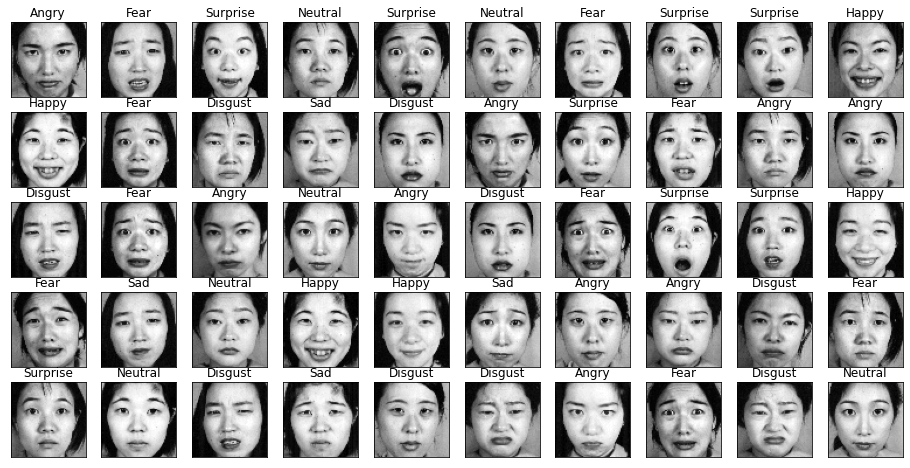

In [ ]:
import matplotlib.pyplot as plt
# Displaying 25 images from training dataset in 5x5 matrix
emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013, JAFFE
#emotion = {0:'anger',1:'contempt',2:'disgust',3:'fear',4:'happy',5:'sadness',6:'surprise'} #for CK+
def plot_image(input_images,labels,start=0,end=50):
  print("Display 50 images from the train set in the form of 5x5 matrix with their respective labels:")
  plt.figure(figsize=[16,8])
  pos = 0
  for i in range(start,end):
    plt.subplot(5,10,1+pos)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(input_images[i].reshape([img_H,img_W]), cmap='gray')
    plt.title(emotion[int(labels[i])])
    pos +=1
  plt.show()

plot_image(x,y)


Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.05
14/14 [==============================] - 9s 182ms/step - loss: 2.3027 - accuracy: 0.1302 - val_loss: 2.1162 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to /content/saved_models/JAFFE_model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
Learning rate:  0.05
14/14 [==============================] - 1s 56ms/step - loss: 2.1209 - accuracy: 0.1510 - val_loss: 2.0847 - val_accuracy: 0.3333

Epoch 00002: val_accuracy improved from 0.00000 to 0.33333, saving model to /content/saved_models/JAFFE_model.h5
Epoch 3/200
Learning rate:  0.05
14/14 [==============================] - 1s 48ms/step - loss: 2.1096 - accuracy: 0.1146 - val_loss: 2.0982 - val_accuracy: 0.3333

Epoch 00003: val_accuracy did not improve from 0.33333
Epoch 4/200
Learning rate:  0.05
14/14 [==============================] - 1s 46ms/step - loss: 2.1031 - accuracy: 0.1406 - val_loss: 2.1007 - val_accuracy: 0.1429

Epoch 00004: val_accuracy did not improve from 0.33333
Epoch 5/200
Learning rate:  0.05
14/14 [==============================] - 1s 49ms/step - loss: 2.0981 - accuracy: 0.1562 - val_loss: 2.1116 - val_accuracy: 0.0476

Epoch 00005: val_accuracy did not improve from 0.33333
Epoch 6/200
Learning rate:  0.05
14/14 [==========================

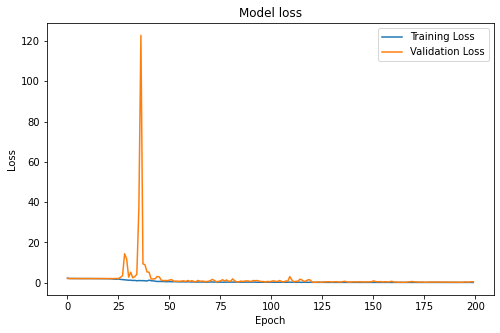

Plot the accuracy (Train and Validation)


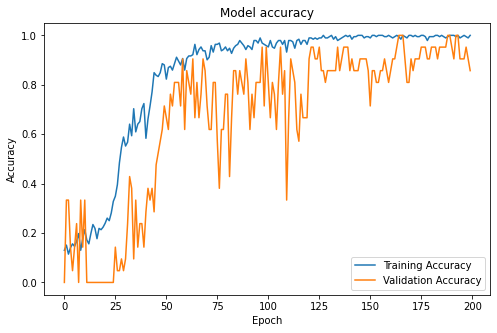

In [16]:
#CBAM 

from __future__ import print_function
import keras
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import resnet_v1, mobilenets
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import callbacks as cb

# Training parameters
batch_size = 14
epochs = 200
data_augmentation = True
num_classes = 7

attention_module = 'cbam_block'
base_model = 'ResNet18'
dataset_type = 'JAFFE'


# Load dataset.
x_train, x_val, y_train, y_val = train_test_split(x, y,test_size=21, random_state=2021)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=21, random_state=2021)

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)


depth = 20 # For ResNet, specify the depth (e.g. ResNet50: depth=50, ResNet101: Depth=101)
model = resnet_v1.resnet_v1(input_shape=input_shape, depth=depth,num_classes=7, attention_module='cbam_block')
#model = mobilenets.MobileNet(input_shape=input_shape, classes=num_classes, attention_module='cbam_block')
#model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=lr_schedule(0)),metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer= SGD(decay=2e-4, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
#model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = dataset_type + '_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
def lr_schedule(epoch):
    lr = 0.05
    if epoch >= (epochs*0.6):
      lr=0.005
    elif epoch >= (epochs*0.2):
      lr=0.01
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    #history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val), shuffle=True,callbacks=callbacks)
    history = model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs,validation_data=(x_val, y_val),verbose=1,shuffle=True,callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    #history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_val, y_val),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

def plot_model_history(history):
  # Plot training loss values
  print("Plot loss values (Train vs. Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'],label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

  print("Plot the accuracy (Train and Validation)")
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['accuracy'],label='Training Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

plot_model_history(history)


In [17]:
#Testing the predition
best_model = keras.models.load_model('/content/saved_models/'+ dataset_type + '_model.h5')
scores = best_model.evaluate(x_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.2576 - accuracy: 1.0000


Labels Dictionary:
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
Number of predition samples =  21


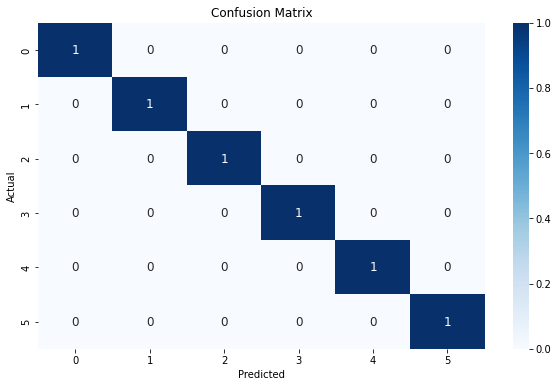

In [18]:
#test images
from sklearn.metrics import confusion_matrix
import seaborn as sn
emotion={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'} #for FER2013, JAFFE

print('Labels Dictionary:')
print(emotion)
print('Number of predition samples = ', len(x_test))
pred = best_model.predict(x_test)
cm = confusion_matrix( np.argmax(y_test,1),pred.argmax(1),normalize='pred')
#cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize =(10,6))
sn.heatmap(cm, annot=True, annot_kws={"size": 12},cmap=plt.cm.Blues) # font size
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()